In [1]:
import random
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")
rs = np.random.RandomState(0)
% matplotlib inline
% config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['font.size'] = 16
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
from visualize import *
from calibration import *
from collections import defaultdict
from tqdm import tqdm
from spline import *


NUM_BINS = 10
NUM_CLASSES =  100
NUM_CLASSES_PLOT = 4
NUM_COL = 5
NUM_RUN = 50
# limit to the cases when the number of samples is less than 1000
NUM_SAMPLES = [100] + [50 * _ for _ in range(3, 20)] 
print len(NUM_SAMPLES)
METHOD_NAME = "binary_spline"

18


try out the PyGAM package (e.g., Logistic GAM with splines) for one or more of our datasets (e.g., p(y=1 | max_k s_k(x)) for calibration, or Accuracy( g (x) ) versus g(x) where g(x) is brightness - to get a sense whether this approach is a bit more robust than (say) GP classification methods.

In [2]:
# Load prediction from ResNet on CIFAR100 test data, which contains 10,000 images. 
# https://github.com/rloganiv/pytorch-classification/blob/master/predict.py
# data: a numpy array of size 10,000 * 101. For each row, the first entry is the true label,
#       following by softmax of output logits of this image for each class.
DATASET = "cifar100_predictions_dropout"
data = np.genfromtxt("data/%s.txt" % DATASET)# 10000*101
score = data[:,1:]
Y_predict = np.argmax(score, axis=1)
Y_true = data[:,0]

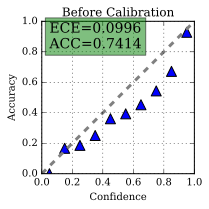

In [3]:
fig, ax = plt.subplots()
fig.set_figheight(3)
fig.set_figwidth(3)
ece, acc, ax = reliability_plot(ax, score, Y_true, NUM_BINS)
ax.set_title("Before Calibration")
fig.tight_layout()

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


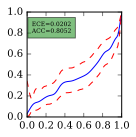

In [4]:
# feed all data into spline regression
fig, ax = plt.subplots()
fig.set_figheight(2)
fig.set_figwidth(2)
ece, acc, ax = spline_classification_plot(ax,
                           np.max(score, axis=1).reshape(-1, 1),
                           np.array(Y_true == Y_predict) * 1)
fig.tight_layout()

# randomly select datapoints and feed to spline regression

In [5]:
ece_random = dict()
acc_random = dict()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |#######################

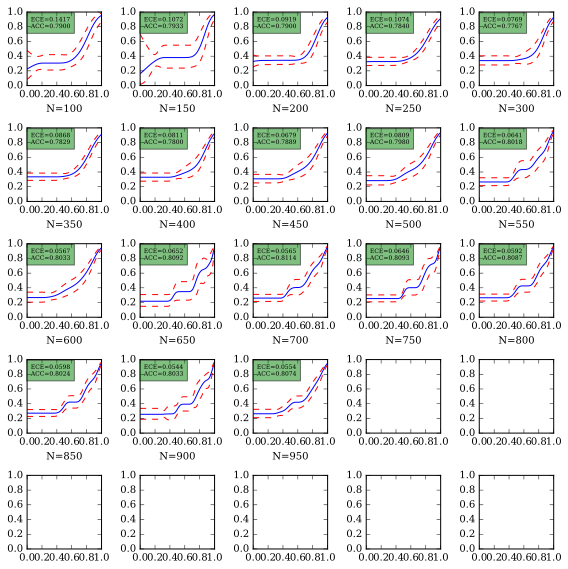

In [6]:
# one run and plot fitted spline regression model
# randomly select datapoints and feed to spline regression
fig, ax = plt.subplots(nrows=5, ncols=5)
fig.set_figheight(8)
fig.set_figwidth(8)
idx_list = []
training_idx = [i for i in range(10000)]
for idx in range(len(NUM_SAMPLES)):
    n_inc = NUM_SAMPLES[idx] - len(idx_list)
    idx_list += np.random.choice([i for i in training_idx if i not in idx_list], 
                              size = n_inc,
                              replace = False).tolist()
    ece, acc, ax[idx / NUM_COL, idx % NUM_COL] = \
                                spline_classification_plot(ax[idx / NUM_COL, idx % NUM_COL],
                                np.max(score[idx_list], axis=1).reshape(-1, 1),
                                np.array(Y_true == Y_predict)[idx_list] * 1);
    ece_random[len(idx_list)] = ece[0]
    acc_random[len(idx_list)] = acc
    ax[idx / NUM_COL, idx % NUM_COL].set_xlabel("N=%d" % NUM_SAMPLES[idx])
fig.tight_layout()

# actively select datapoints and feed into spline regression

In [7]:
ece_active = dict()
acc_active = dict()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |#######################

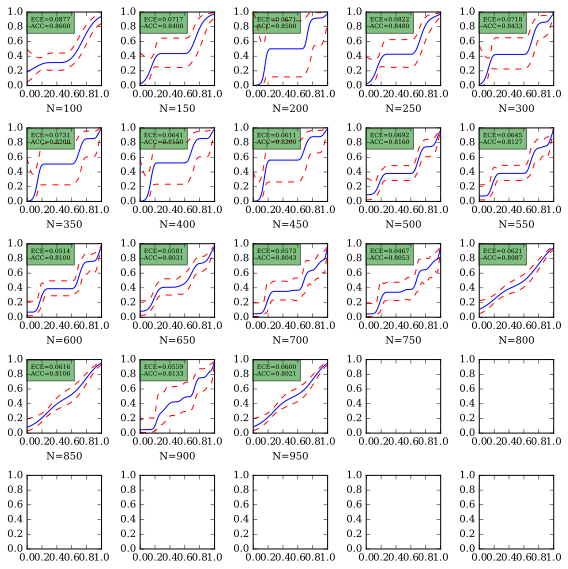

In [8]:
# one run and plot fitted spline regression model
# randomly select datapoints and feed to spline regression
fig, ax = plt.subplots(nrows=5, ncols=5)
fig.set_figheight(8)
fig.set_figwidth(8)
idx_list = []
training_idx = [i for i in range(10000)]
for idx in range(len(NUM_SAMPLES)):
    if idx == 0:
        n_inc = NUM_SAMPLES[0]
        candidate_list = [i for i in training_idx if i not in idx_list]
        idx_list += np.random.choice(candidate_list, 
                                     size = n_inc,
                                     replace = False).tolist()
    else:
        n_inc = NUM_SAMPLES[idx] - len(idx_list)
        candidate_list = [i for i in training_idx if i not in idx_list]
        p = weights[candidate_list,0] / weights[candidate_list].sum()
        idx_list += np.random.choice(candidate_list, 
                                     size = n_inc,
                                     replace = False,
                                     p = p).tolist()
    ece, acc, ax[idx / NUM_COL, idx % NUM_COL] = \
                                spline_classification_plot(ax[idx / NUM_COL, idx % NUM_COL],
                                np.max(score[idx_list], axis=1).reshape(-1, 1),
                                np.array(Y_true == Y_predict)[idx_list] * 1)
    ax[idx / NUM_COL, idx % NUM_COL].set_xlabel("N=%d" % NUM_SAMPLES[idx])
    ece_active[len(idx_list)] = ece[0]
    acc_active[len(idx_list)] = acc
    confi = get_spline_uncertainty(np.max(score[idx_list], axis=1).reshape(-1, 1),
                            np.array(Y_true == Y_predict)[idx_list] * 1)
    confi = sigmoid(confi) # 100 * 1
    uncertainty = confi[:,1] - confi[:, 0]
    # compute probablity of each datapoint
    digitized = np.digitize(np.max(score, axis=1).reshape(-1, 1), 
                            np.linspace(0, 1, 10)) -1
    weights = uncertainty[digitized]
fig.tight_layout()

# Compare random / active selecting in a single run

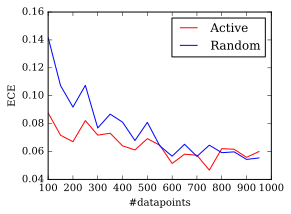

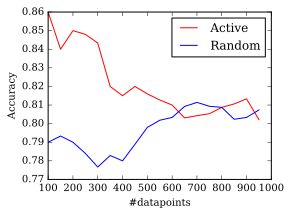

In [9]:
plt.figure(figsize = (4,3))
plt.plot(NUM_SAMPLES, 
             [ece_active[_] for _ in NUM_SAMPLES], 
             c = 'r', label="Active")
plt.plot(NUM_SAMPLES, 
             [ece_random[_] for _ in NUM_SAMPLES], 
             c = 'b', label="Random")
plt.xlabel("#datapoints")
plt.ylabel("ECE")
plt.legend()
plt.figure(figsize = (4,3))
plt.plot(NUM_SAMPLES, 
             [acc_active[_] for _ in NUM_SAMPLES], 
             c = 'r', label="Active")
plt.plot(NUM_SAMPLES, 
             [acc_random[_] for _ in NUM_SAMPLES],
             c = 'b', label="Random")
plt.xlabel("#datapoints")
plt.ylabel("Accuracy")
plt.legend()

# Multiple runs to get errorbar

In [13]:
######### run spline_run.py for a given dataset for multiple runs.
# results will be written to output/DATASET with filenames ece_random.csv, 
# ece_active.csv, acc_random.csv, acc_active.csv.

# disij@datalab-5 22:19:44 ~/projects/sandbox/nn_assessor
# python spline_run.py


######### load the results
def loadcsv(filename):
    """
    INPUT:
        filename:  a csv file. can be ece_random, ece_active, acc_random, 
                    acc_active in this case.
    OUTPUT:
        result_dict: defaultdict(list). can be ece_random, ece_active, 
                    acc_random, acc_active in this case.
    """
    import csv
    result_dict = defaultdict(list)
    with open(filename, 'r') as f:
        for line in f.readlines():
            line = line.split(",")
            result_dict[int(line[0])].append([float(_) for _ in line[1:]])
    return result_dict

ece_random_multi_run = loadcsv("output/%s/ece_random.csv" % DATASET)
acc_random_multi_run = loadcsv("output/%s/acc_random.csv" % DATASET)
ece_active_multi_run = loadcsv("output/%s/ece_active.csv" % DATASET)
acc_active_multi_run = loadcsv("output/%s/acc_active.csv" % DATASET)

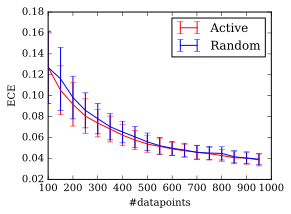

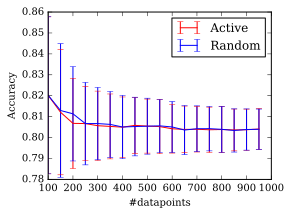

In [14]:
plt.figure(figsize = (4,3))
plt.errorbar(NUM_SAMPLES, 
             [np.mean(ece_active_multi_run[_]) for _ in NUM_SAMPLES], 
             yerr = [np.std(ece_active_multi_run[_]) for _ in NUM_SAMPLES],
             c = 'r', label="Active")
plt.errorbar(NUM_SAMPLES, 
             [np.mean(ece_random_multi_run[_]) for _ in NUM_SAMPLES], 
             yerr = [np.std(ece_random_multi_run[_]) for _ in NUM_SAMPLES],
             c = 'b', label="Random")
plt.xlabel("#datapoints")
plt.ylabel("ECE")
plt.legend()
plt.figure(figsize = (4,3))
plt.errorbar(NUM_SAMPLES, 
             [np.mean(acc_active_multi_run[_]) for _ in NUM_SAMPLES], 
             yerr = [np.std(acc_active_multi_run[_]) for _ in NUM_SAMPLES],
             c = 'r', label="Active")
plt.errorbar(NUM_SAMPLES, 
             [np.mean(acc_random_multi_run[_]) for _ in NUM_SAMPLES], 
             yerr = [np.std(acc_random_multi_run[_]) for _ in NUM_SAMPLES],
             c = 'b', label="Random")
plt.xlabel("#datapoints")
plt.ylabel("Accuracy")
plt.legend()

In [12]:
# # per class
# # comment out for now.
# fig, ax = plt.subplots(NUM_CLASSES_PLOT/NUM_COL, NUM_COL, sharex='col', sharey='row')
# fig.set_figheight(5)
# fig.set_figwidth(5)
# for K in range(NUM_CLASSES_PLOT):
#     ax[K/NUM_COL, K%NUM_COL] = spline_classification(ax[K/NUM_COL, K%NUM_COL],
#                                              p[:,K:K+1],
#                                              np.array((Y_true == K)) * 1)
# fig.tight_layout()